# Setup

In [1]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
    !pip3 install git+https://github.com/pvigier/perlin-numpy astropy geopy
%pwd

/home/jovyan/AI-Event-Monitoring
  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-aa8enw60
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-aa8enw60
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done


'/home/jovyan/AI-Event-Monitoring'

In [2]:
import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (16,8)

from tensorflow.keras.models import load_model
from osgeo                   import gdal
from PIL                     import Image
from src.io                  import get_image_array
from src.inference           import mask_with_model, mask_simulated
from src.sarsim              import gen_simulated_deformation, gen_sim_noise, gen_simulated_time_series

In [3]:
def plot_results(wrapped, mask, presence_mask):

    _, [axs_wrapped, axs_mask, axs_presence_mask] = plt.subplots(1, 3)

    axs_wrapped.set_title('Wrapped')
    axs_mask.set_title('Segmentation Mask')
    axs_presence_mask.set_title('Presence Mask')
    
    axs_wrapped.imshow(wrapped, origin='lower', cmap='jet')
    axs_mask.imshow(mask, origin='lower', cmap='jet')
    axs_presence_mask.imshow(presence_mask, origin='lower', cmap='jet')

In [4]:
def mask_simulated(
    mask_model,
    seed:           int,
    tile_size:      int,
    crop_size:      int   = 0,
    verbose:        bool  = False,
    noise_only:     bool  = False,
    gaussian_only:  bool  = False,
    zero_output:    bool  = False,
    event_type:     str   = 'quake',
    tolerance:      float = 0.7
) -> None:

    """
    Predicts the event-mask on a synthetic wrapped interferogram and plots the results.

    Parameters:
    -----------
    model_path : str
        The path to the model that does the masking.
    seed : int
        A seed for the random functions. For the same seed, with all other values the same
        as well, the interferogram generation will have the same results. If left at 0,
        the results will be different every time.
    tile_size : int
        The dimensional size of the simulated interferograms to generate, this must match the
        input shape of the model.
    crop_size : int, Optional
        If the models output shape is different than the input shape, this value needs to be
        equal to the output shape.
    use_sim : bool, Optional
        Use simulated interferograms rather than synthetic interferograms

    Returns:
    --------
    None
    """

    n_interferograms = 16
    
    if crop_size == 0:
        crop_size = tile_size

    if not noise_only:
        phases, mask = gen_simulated_time_series(
            n_interferograms = n_interferograms,
            seed       = seed,
            tile_size  = tile_size,
            noise_only = False
        )
    else:
        phases, mask = gen_simulated_time_series(
            n_interferograms = n_interferograms,
            seed       = seed,
            tile_size  = tile_size,
            noise_only = True,
        )

    input_phases = phases[:, 0, :, :]
    
    print(mask.shape)
    
    wrapped   = input_phases.transpose().swapaxes(0, 1)
    wrapped   = wrapped.reshape((1, *wrapped.shape, 1))
    mask_pred = np.float32(mask_model.predict(wrapped))

    return input_phases, mask, mask_pred

# Generate Mask

In [5]:
tile_size = 512
crop_size = 512

mask_model_path = 'notebooks/models/time_series_masking_model'

mask_model = load_model(mask_model_path)

wrapped, mask, mask_pred = mask_simulated(mask_model, seed=0, tile_size=512)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
(512, 512)


# Process Mask

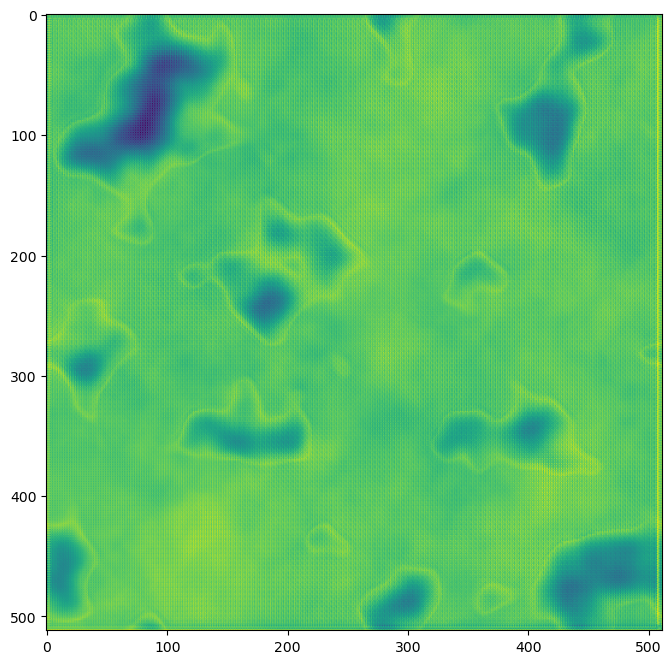

In [6]:
mask_accumulated = np.zeros((512, 512))
for i in range(16):
    mask_accumulated += mask_pred[0, :, :, i, 0]
plt.imshow(np.angle(np.exp(1j * mask_accumulated)))

(1, 512, 512, 16, 1)


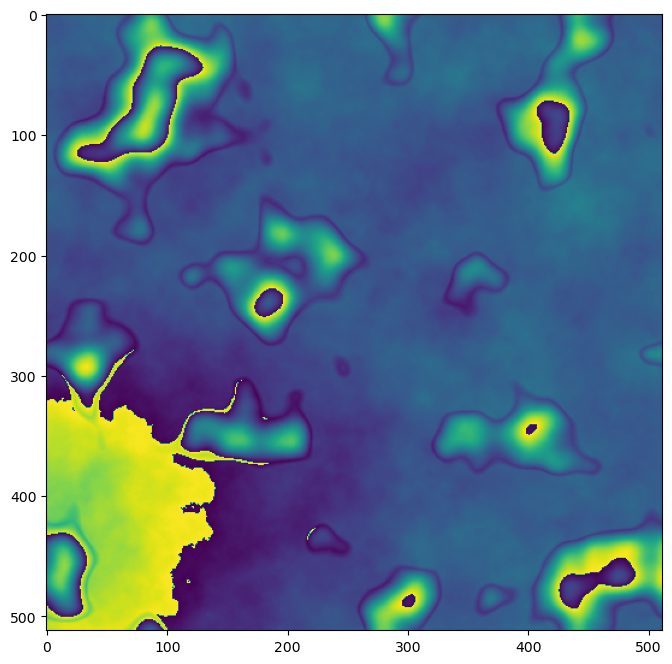

In [7]:
wrapped_copy = wrapped.transpose().swapaxes(0, 1)
wrapped_copy = wrapped_copy.reshape((1, *wrapped_copy.shape, 1))

print(wrapped_copy.shape)

arr = np.zeros((512, 512))
for i in range(16):
    arr += wrapped_copy[0, :, :, i, 0]

plt.imshow(np.angle(np.exp(1j * arr)))

# Plot Mask

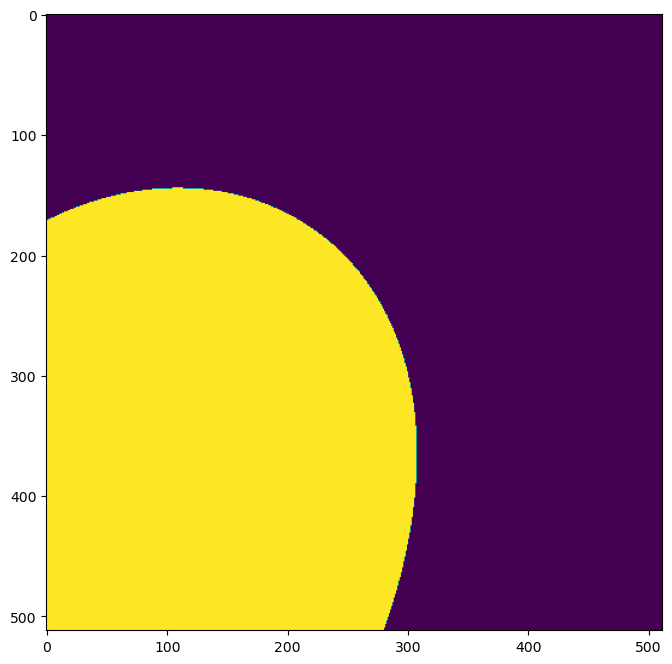

In [8]:
plt.imshow(mask)